In [ ]:
import pickle
# import emoji
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import MWETokenizer, TweetTokenizer, word_tokenize
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# from transformers import BertTokenizer

# import torch
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression


In [ ]:
!pip install emoji
import emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=8aa325012bbaa23d1d9f3c7bf0e598a624cb60f4e9ff1e301a0a193db433b55f
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
with open('data/dumped/tweets.pkl','rb') as f:
    X, y = pickle.load(f)

In [ ]:
len(y)

420

## Average Tweet Length

In [ ]:
get_tweets_length = lambda doc: np.array(
    [len(tweet) for tweet in doc], dtype=np.int32)

def get_categorical_tweets_length(label, docs=X, labels=y):
    """
    Returns a list of tweets lengths for each category.
    """
    tweets_length = np.empty(docs[labels == label].shape, dtype=np.int32)
    for index, user in enumerate(docs[labels == label]):
        tweets_length[index, :] = get_tweets_length(user)

    return tweets_length

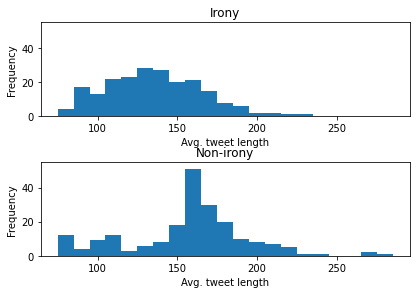

In [ ]:
i_tweets_length_per_user = np.mean(get_categorical_tweets_length('I'), axis=1)
ni_tweets_length_per_user = np.mean(get_categorical_tweets_length('NI'), axis=1)

plt.subplot(2, 1, 1)
plt.title('Irony')
plt.xlabel('Avg. tweet length')
plt.ylabel('Frequency')
plt.tight_layout()
axes = plt.gca()
axes.set_ylim([0, 55])
plt.hist(i_tweets_length_per_user, 21, range=[75, 285]);
plt.subplot(2, 1, 2)
plt.tight_layout()
plt.title('Non-irony')
plt.xlabel('Avg. tweet length')
plt.ylabel('Frequency')
axes = plt.gca()
axes.set_ylim([0, 55])
plt.hist(ni_tweets_length_per_user, 21, range=[75, 285]);

In [ ]:
np.mean(i_tweets_length_per_user), np.mean(ni_tweets_length_per_user)

(136.01752380952382, 156.02366666666668)

In [ ]:
np.median(i_tweets_length_per_user), np.median(ni_tweets_length_per_user)

(134.5125, 160.1525)

## Emojis

In [ ]:
extract_emojis = lambda text: [d['emoji'] for d in emoji.emoji_list(text)]
emoji_dict = dict([(i, 0) for i in list(emoji.EMOJI_DATA.keys())])

In [ ]:
def get_emojis(label, emoji_dict=emoji_dict, doc=X, labels=y):
    """
    Returns: a) a list of vector for emojis from the given label
             b) a list of number of emojis from users
    """
    emojis, counts = [], []
    for user in doc[labels == label]:
        user_counts = 0
        user_emojis = emoji_dict.copy()
        for tweet in user:
            extracted_emoji = extract_emojis(tweet)
            user_counts += len(extracted_emoji)
            for emoji in extracted_emoji:
                user_emojis[emoji] += 1
        emojis.append(user_emojis)
        counts.append(user_counts)

    return emojis, counts

In [ ]:
i_emojis, i_emoji_counts = get_emojis('I')
ni_emojis, ni_emoji_counts = get_emojis('NI')

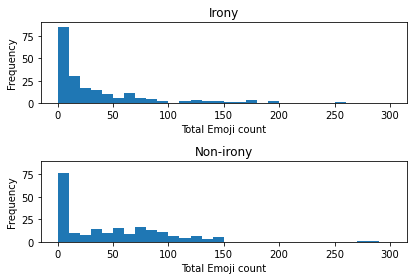

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Irony')
plt.xlabel('Total Emoji count')
plt.ylabel('Frequency')
plt.tight_layout()
axes = plt.gca()
axes.set_ylim([0, 90])
plt.hist(i_emoji_counts, 30, range=[0, 300]);
plt.subplot(2, 1, 2)
plt.title('Non-irony')
plt.xlabel('Total Emoji count')
plt.ylabel('Frequency')
plt.tight_layout()
axes = plt.gca()
axes.set_ylim([0, 90])
plt.hist(ni_emoji_counts, 30, range=[0, 300]);

In [ ]:
emoji_vectors = list(emoji_dict.keys())

get_categorical_emojis_vector = lambda d: np.sum(
    [np.array(list(emojis.values())) for emojis in d], axis=0)

i_emoji_vectors = get_categorical_emojis_vector(i_emojis)
ni_emoji_vectors = get_categorical_emojis_vector(ni_emojis)

get_sorted_emoji_dict = lambda categorical_vec, emoji_vec=emoji_vectors: dict(
    sorted([(emoji_vec[i], categorical_vec[i]) for i in range(
        len(emoji_vec))], key=lambda x: x[1], reverse=True))

i_emojis_dict = get_sorted_emoji_dict(i_emoji_vectors)
ni_emojis_dict = get_sorted_emoji_dict(ni_emoji_vectors)

In [ ]:
print(list(i_emojis_dict.keys())[:15])

['😂', '🤣', '🤔', '🙄', '😉', '👍', '👇', '❤️', '🤦\u200d♂️', '🤷\u200d♂️', '😒', '😄', '😏', '😁', '😊']


In [ ]:
print(list(ni_emojis_dict.keys())[:15])

['😂', '😭', '🤣', '✅', '🔥', '❤️', '🤔', '🙏', '🙄', '🇺🇸', '💀', '🚀', '👇', '😩', '🇺🇦']


## Training

In [ ]:
forest = RandomForestClassifier(n_estimators=2000)
svm = SVC(kernel='rbf', C=1.0, random_state=42)
logistic_regression = LogisticRegression(C=1.0, random_state=42)

### Average Tweet Length

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in train_labels_cv])
    test_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in test_labels_cv])

    train_average_length = np.mean(
        np.array([get_tweets_length(user) for user in train_data_cv]),
        axis=1).reshape(-1, 1)

    forest.fit(train_average_length, train_labels_cv)
    svm.fit(train_average_length, train_labels_cv)
    logistic_regression.fit(train_average_length, train_labels_cv)

    test_average_length = np.mean(
        np.array([get_tweets_length(user) for user in test_data_cv]),
        axis=1).reshape(-1, 1)

    forest_score = forest.score(test_average_length, test_labels_cv)
    svm_score = svm.score(test_average_length, test_labels_cv)
    logistic_regression_score = logistic_regression.score(
        test_average_length, test_labels_cv)
    
    print('RF:', forest_score, '\t', 'SVM:', svm_score, '\t', 
          'LR:', logistic_regression_score)

    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    # print(classification_report(test_labels_cv, prediction))

    scores.append((forest_score, svm_score, logistic_regression_score))

mean_scores = np.mean(scores, axis=0)
print('\nAVG RF SCORE:', mean_scores[0],
      '\nAVG SVM SCORE:', mean_scores[1],
      '\nAVG LR SCORE:', mean_scores[2])

RF: 0.6309523809523809 	 SVM: 0.7738095238095238 	 LR: 0.7738095238095238
RF: 0.5952380952380952 	 SVM: 0.7261904761904762 	 LR: 0.7023809523809523
RF: 0.4523809523809524 	 SVM: 0.6547619047619048 	 LR: 0.6190476190476191
RF: 0.6309523809523809 	 SVM: 0.6666666666666666 	 LR: 0.6428571428571429
RF: 0.6428571428571429 	 SVM: 0.6904761904761905 	 LR: 0.6666666666666666

AVG RF SCORE: 0.5904761904761904 
AVG SVM SCORE: 0.7023809523809523 
AVG LR SCORE: 0.680952380952381


### Emoji Usage

In [ ]:
def get_emoji_usage(user, emoji_dict=emoji_dict):
    """
    Returns: a) a list of vector for emojis from the given profile
             b) a list of number of emojis from this user
    """
    counts = 0
    user_emoji_dict = copy.deepcopy(emoji_dict)

    for tweet in user:
        extracted_emoji = extract_emojis(tweet)
        counts += len(extracted_emoji)
        for emoji in extracted_emoji:
            user_emoji_dict[emoji] += 1

    emojis = np.array(list(user_emoji_dict.values()))

    return emojis, counts

#### Emoji Counts

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv_original, test_labels_cv_original = y[train], y[test]

    train_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in train_labels_cv_original])
    test_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in test_labels_cv_original])

    train_emoji_usage = np.array(
        [get_emoji_usage(user)[1] for user in train_data_cv]).reshape(-1, 1)

    forest.fit(train_emoji_usage, train_labels_cv)
    svm.fit(train_emoji_usage, train_labels_cv)
    logistic_regression.fit(train_emoji_usage, train_labels_cv)

    test_emoji_usage = np.array(
        [get_emoji_usage(user)[1] for user in test_data_cv]).reshape(-1, 1)

    forest_score = forest.score(test_emoji_usage, test_labels_cv)
    svm_score = svm.score(test_emoji_usage, test_labels_cv)
    logistic_regression_score = logistic_regression.score(
        test_emoji_usage, test_labels_cv)
    
    print('RF:', forest_score, '\t', 'SVM:', svm_score, '\t', 
          'LR:', logistic_regression_score)

    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    # print(classification_report(test_labels_cv, prediction))

    scores.append((forest_score, svm_score, logistic_regression_score))

mean_scores = np.mean(scores, axis=0)
print('\nAVG RF SCORE:', mean_scores[0],
      '\nAVG SVM SCORE:', mean_scores[1],
      '\nAVG LR SCORE:', mean_scores[2])

RF: 0.6428571428571429 	 SVM: 0.6190476190476191 	 LR: 0.4523809523809524
RF: 0.5476190476190477 	 SVM: 0.5476190476190477 	 LR: 0.5476190476190477
RF: 0.6547619047619048 	 SVM: 0.6785714285714286 	 LR: 0.5833333333333334
RF: 0.7023809523809523 	 SVM: 0.6071428571428571 	 LR: 0.5595238095238095
RF: 0.5119047619047619 	 SVM: 0.5714285714285714 	 LR: 0.5238095238095238

AVG RF SCORE: 0.6119047619047618 
AVG SVM SCORE: 0.6047619047619047 
AVG LR SCORE: 0.5333333333333334


#### Emoji Vectors

In [ ]:
# No Optimization; Time Killer!

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv_original, test_labels_cv_original = y[train], y[test]

    train_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in train_labels_cv_original])
    test_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in test_labels_cv_original])

    train_emoji_usage = np.array(
        [get_emoji_usage(user)[0] for user in train_data_cv])

    forest.fit(train_emoji_usage, train_labels_cv)
    svm.fit(train_emoji_usage, train_labels_cv)
    logistic_regression.fit(train_emoji_usage, train_labels_cv)

    test_emoji_usage = np.array(
        [get_emoji_usage(user)[0] for user in test_data_cv])

    forest_score = forest.score(test_emoji_usage, test_labels_cv)
    svm_score = svm.score(test_emoji_usage, test_labels_cv)
    logistic_regression_score = logistic_regression.score(
        test_emoji_usage, test_labels_cv)
    
    print('RF:', forest_score, '\t', 'SVM:', svm_score, '\t', 
          'LR:', logistic_regression_score)

    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    # print(classification_report(test_labels_cv, prediction))

    scores.append((forest_score, svm_score, logistic_regression_score))

mean_scores = np.mean(scores, axis=0)
print('\nAVG RF SCORE:', mean_scores[0],
      '\nAVG SVM SCORE:', mean_scores[1],
      '\nAVG LR SCORE:', mean_scores[2])

RF: 0.7261904761904762 	 SVM: 0.6904761904761905 	 LR: 0.5952380952380952


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.7738095238095238 	 SVM: 0.6785714285714286 	 LR: 0.6904761904761905
RF: 0.7738095238095238 	 SVM: 0.7142857142857143 	 LR: 0.6904761904761905
RF: 0.6904761904761905 	 SVM: 0.6547619047619048 	 LR: 0.6309523809523809
RF: 0.6190476190476191 	 SVM: 0.6904761904761905 	 LR: 0.6071428571428571

AVG RF SCORE: 0.7166666666666667 
AVG SVM SCORE: 0.6857142857142857 
AVG LR SCORE: 0.6428571428571428


### Tokenization

#### BERT

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
special_tokens = ['#USER#', '#HASHTAG#', '#URL#']
special_tokens_dict = {
    'additional_special_tokens': special_tokens}
bert_tokenizer.add_special_tokens(special_tokens_dict)

3

In [ ]:
# No Optimization; Time Killer!
### words

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv_original, test_labels_cv_original = y[train], y[test]

    bert_tokens_dict = {}
    for user in train_data_cv:
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                bert_tokens_dict[token] = 0


    train_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in train_labels_cv_original])
    test_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in test_labels_cv_original])

    ##### train
    trains_vector_cv = np.zeros((
        len(train_data_cv), len(bert_tokens_dict)))
    for index, user in enumerate(train_data_cv):
        user_tokens = copy.deepcopy(bert_tokens_dict)
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                user_tokens[token] += 1
        trains_vector_cv[index] = np.array(
            list(user_tokens.values()))

    forest.fit(trains_vector_cv, train_labels_cv)
    svm.fit(trains_vector_cv, train_labels_cv)
    logistic_regression.fit(trains_vector_cv, train_labels_cv)

    ##### validation
    tests_vector_cv = np.zeros((
        len(test_data_cv), len(bert_tokens_dict)))
    for index, user in enumerate(test_data_cv):
        user_tokens = copy.deepcopy(bert_tokens_dict)
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                try:
                    user_tokens[token] += 1
                except KeyError:
                    pass
        tests_vector_cv[index] = np.array(
            list(user_tokens.values()))

    forest_score = forest.score(tests_vector_cv, test_labels_cv)
    svm_score = svm.score(tests_vector_cv, test_labels_cv)
    logistic_regression_score = logistic_regression.score(
        tests_vector_cv, test_labels_cv)
    
    print('RF:', forest_score, '\t', 'SVM:', svm_score, '\t', 
          'LR:', logistic_regression_score)

    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    # print(classification_report(test_labels_cv, prediction))

    scores.append((forest_score, svm_score, logistic_regression_score))

mean_scores = np.mean(scores, axis=0)
print('\nAVG RF SCORE:', mean_scores[0],
      '\nAVG SVM SCORE:', mean_scores[1],
      '\nAVG LR SCORE:', mean_scores[2])

: 

: 

In [ ]:
bert_tokens_dict = {}
for user in train_data_cv:
    for tweet in user:
        tokens = set(bert_tokenizer.tokenize(tweet))
        for token in tokens:
            bert_tokens_dict[token] = 0

trains_vector_cv = np.zeros((
        len(train_data_cv), len(bert_tokens_dict)))

In [ ]:
for index, user in enumerate(train_data_cv):
    user_tokens = copy.deepcopy(bert_tokens_dict)
    for tweet in user:
        tokens = set(bert_tokenizer.tokenize(tweet))
        for token in tokens:
            user_tokens[token] += 1
    trains_vector_cv[index] = np.array(
                    list(user_tokens.values()))

In [ ]:
trains_vector_cv.shape

(336, 24515)

In [ ]:
trains_vector_cv = np.zeros((
        len(train_data_cv), len(bert_tokens_dict)))

In [ ]:
trains_vector_cv.shape

(336, 24515)

In [ ]:
print([token for token in tokens])

['#USER#', '#USER#', '#USER#', 'putin', 'is', 'mentally', 'un', '##hing', '##ed', ',', 'he', 'needs', 'to', 'be', 'in', 'a', 'strait', 'jacket', '.']


In [ ]:
len(bert_tokens_dict)

24515

#### MWE Tokenizer

In [ ]:
mwe_tokenizer = MWETokenizer()

In [ ]:
# No Optimization; Time Killer!

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv_original, test_labels_cv_original = y[train], y[test]

    mwe_tokens_dict = {}
    for user in train_data_cv:
        for tweet in user:
            tokens = set(mwe_tokenizer.tokenize(word_tokenize(tweet.lower())))
            for token in tokens:
                mwe_tokens_dict[token] = 0

    train_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in train_labels_cv_original])
    test_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in test_labels_cv_original])

    trains_vector_cv = np.zeros((
        len(train_data_cv), len(mwe_tokens_dict)))
    for index, user in enumerate(train_data_cv):
        user_tokens = copy.deepcopy(mwe_tokens_dict)
        for tweet in user:
            tokens = set(mwe_tokenizer.tokenize(word_tokenize(tweet.lower())))
            for token in tokens:
                user_tokens[token] += 1
        trains_vector_cv[index] = np.array(
            list(user_tokens.values()))

    forest.fit(trains_vector_cv, train_labels_cv)
    svm.fit(trains_vector_cv, train_labels_cv)
    logistic_regression.fit(trains_vector_cv, train_labels_cv)

    tests_vector_cv = np.zeros((
        len(test_data_cv), len(mwe_tokens_dict)))
    for index, user in enumerate(test_data_cv):
        user_tokens = copy.deepcopy(mwe_tokens_dict)
        for tweet in user:
            tokens = set(mwe_tokenizer.tokenize(word_tokenize(tweet.lower())))
            for token in tokens:
                try:
                    user_tokens[token] += 1
                except KeyError:
                    pass
        tests_vector_cv[index] = np.array(
            list(user_tokens.values()))

    forest_score = forest.score(tests_vector_cv, test_labels_cv)
    svm_score = svm.score(tests_vector_cv, test_labels_cv)
    logistic_regression_score = logistic_regression.score(
        tests_vector_cv, test_labels_cv)
    
    print('RF:', forest_score, '\t', 'SVM:', svm_score, '\t', 
          'LR:', logistic_regression_score)

    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    # print(classification_report(test_labels_cv, prediction))

    scores.append((forest_score, svm_score, logistic_regression_score))

mean_scores = np.mean(scores, axis=0)
print('\nAVG RF SCORE:', mean_scores[0],
      '\nAVG SVM SCORE:', mean_scores[1],
      '\nAVG LR SCORE:', mean_scores[2])

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9404761904761905 	 SVM: 0.8928571428571429 	 LR: 0.9166666666666666


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8809523809523809 	 SVM: 0.9047619047619048 	 LR: 0.9404761904761905


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8690476190476191 	 SVM: 0.8928571428571429 	 LR: 0.9166666666666666


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8690476190476191 	 SVM: 0.8571428571428571 	 LR: 0.8571428571428571


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9642857142857143 	 SVM: 0.8809523809523809 	 LR: 0.9047619047619048

AVG RF SCORE: 0.9047619047619048 
AVG SVM SCORE: 0.8857142857142858 
AVG LR SCORE: 0.9071428571428571


In [ ]:
len(mwe_tokens_dict)

73994

#### Twitter Tokenizer

In [ ]:
twitter_tokenizer = TweetTokenizer()

In [ ]:
# No Optimization; Time Killer!

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv_original, test_labels_cv_original = y[train], y[test]

    twitter_token_dict = {}
    for user in train_data_cv:
        for tweet in user:
            tokens = set(twitter_tokenizer.tokenize(tweet.lower()))
            for token in tokens:
                twitter_token_dict[token] = 0

    train_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in train_labels_cv_original])
    test_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in test_labels_cv_original])

    trains_vector_cv = np.zeros((
        len(train_data_cv), len(twitter_token_dict)))
    for index, user in enumerate(train_data_cv):
        user_tokens = copy.deepcopy(twitter_token_dict)
        for tweet in user:
            tokens = set(twitter_tokenizer.tokenize(tweet.lower()))
            for token in tokens:
                user_tokens[token] += 1
        trains_vector_cv[index] = np.array(
            list(user_tokens.values()))

    forest.fit(trains_vector_cv, train_labels_cv)
    svm.fit(trains_vector_cv, train_labels_cv)
    logistic_regression.fit(trains_vector_cv, train_labels_cv)

    tests_vector_cv = np.zeros((
        len(test_data_cv), len(twitter_token_dict)))
    for index, user in enumerate(test_data_cv):
        user_tokens = copy.deepcopy(twitter_token_dict)
        for tweet in user:
            tokens = set(twitter_tokenizer.tokenize(tweet.lower()))
            for token in tokens:
                try:
                    user_tokens[token] += 1
                except KeyError:
                    pass
        tests_vector_cv[index] = np.array(
            list(user_tokens.values()))

    forest_score = forest.score(tests_vector_cv, test_labels_cv)
    svm_score = svm.score(tests_vector_cv, test_labels_cv)
    logistic_regression_score = logistic_regression.score(
        tests_vector_cv, test_labels_cv)
    
    print('RF:', forest_score, '\t', 'SVM:', svm_score, '\t', 
          'LR:', logistic_regression_score)

    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    # print(classification_report(test_labels_cv, prediction))

    scores.append((forest_score, svm_score, logistic_regression_score))

mean_scores = np.mean(scores, axis=0)
print('\nAVG RF SCORE:', mean_scores[0],
      '\nAVG SVM SCORE:', mean_scores[1],
      '\nAVG LR SCORE:', mean_scores[2])

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9523809523809523 	 SVM: 0.9047619047619048 	 LR: 0.9166666666666666


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8928571428571429 	 SVM: 0.9047619047619048 	 LR: 0.9404761904761905


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8690476190476191 	 SVM: 0.8809523809523809 	 LR: 0.9166666666666666


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8571428571428571 	 SVM: 0.8452380952380952 	 LR: 0.8571428571428571


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9761904761904762 	 SVM: 0.8809523809523809 	 LR: 0.9047619047619048

AVG RF SCORE: 0.9095238095238095 
AVG SVM SCORE: 0.8833333333333334 
AVG LR SCORE: 0.9071428571428571


In [ ]:
len(twitter_token_dict)

67889

### Concatenation

In [ ]:
# No Optimization; Time Killer!

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv_original, test_labels_cv_original = y[train], y[test]

    bert_tokens_dict = {}
    for user in train_data_cv:
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                bert_tokens_dict[token] = 0

    train_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in train_labels_cv_original])
    test_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in test_labels_cv_original])

    trains_vector_cv = np.zeros((
        len(train_data_cv), len(bert_tokens_dict)))
    for index, user in enumerate(train_data_cv):
        user_tokens = copy.deepcopy(bert_tokens_dict)
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                user_tokens[token] += 1
        trains_vector_cv[index] = np.array(
            list(user_tokens.values()))

    train_emoji_usage = np.array(
        [get_emoji_usage(user)[0] for user in train_data_cv])
    
    train_average_length = np.mean(
        np.array([get_tweets_length(user) for user in train_data_cv]),
        axis=1).reshape(-1, 1)
    
    train_cv = np.hstack((trains_vector_cv,
        train_emoji_usage, train_average_length))

    forest.fit(train_cv, train_labels_cv)
    svm.fit(train_cv, train_labels_cv)
    logistic_regression.fit(train_cv, train_labels_cv)

    tests_vector_cv = np.zeros((
        len(test_data_cv), len(bert_tokens_dict)))
    for index, user in enumerate(test_data_cv):
        user_tokens = copy.deepcopy(bert_tokens_dict)
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                try:
                    user_tokens[token] += 1
                except KeyError:
                    pass
        tests_vector_cv[index] = np.array(
            list(user_tokens.values()))

    test_emoji_usage = np.array(
        [get_emoji_usage(user)[0] for user in test_data_cv])

    test_average_length = np.mean(
        np.array([get_tweets_length(user) for user in test_data_cv]),
        axis=1).reshape(-1, 1)

    test_cv = np.hstack((tests_vector_cv,
        test_emoji_usage, test_average_length))
    
    forest_score = forest.score(test_cv, test_labels_cv)
    svm_score = svm.score(test_cv, test_labels_cv)
    logistic_regression_score = logistic_regression.score(
        test_cv, test_labels_cv)
    
    print('RF:', forest_score, '\t', 'SVM:', svm_score, '\t', 
          'LR:', logistic_regression_score)

    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    # print(classification_report(test_labels_cv, prediction))

    scores.append((forest_score, svm_score, logistic_regression_score))

mean_scores = np.mean(scores, axis=0)
print('\nAVG RF SCORE:', mean_scores[0],
      '\nAVG SVM SCORE:', mean_scores[1],
      '\nAVG LR SCORE:', mean_scores[2])

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9404761904761905 	 SVM: 0.9047619047619048 	 LR: 0.9166666666666666


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8928571428571429 	 SVM: 0.9047619047619048 	 LR: 0.9404761904761905


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8809523809523809 	 SVM: 0.8809523809523809 	 LR: 0.9047619047619048


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8809523809523809 	 SVM: 0.8571428571428571 	 LR: 0.9047619047619048


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9761904761904762 	 SVM: 0.8809523809523809 	 LR: 0.9285714285714286

AVG RF SCORE: 0.9142857142857143 
AVG SVM SCORE: 0.8857142857142858 
AVG LR SCORE: 0.919047619047619


### Voting

### Embeddings

In [ ]:
def load_embedding(filename):
    '''
    Load Word Embedding: return dict, voc size, and dim of embedding
    '''
    embedding_dict = {}
    with open(filename,'r', encoding='utf8') as f:
        for line in f:
            if '\x85' in line:
                split_line = ['\x85'] + line.split()
            else:
                split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            embedding_dict[word] = embedding
    return embedding_dict, len(embedding_dict), len(embedding)

In [ ]:
def get_embedding(profiles,
    tokenizer,
    embedding_dict,
    embedding_dim):
    '''
    Get embedding for profiles
    Input:  profiles: list of profiles
            tokenizer: the method to obtain tokens
            embedding_dict: dict of embedding
            embedding_dim: dimension of embedding
    Return: embedding: numpy array of embedding
    Required: numpy
    '''
    embedding = np.zeros((profiles.shape[0], embedding_dim))
    averaging_embedding = np.zeros((profiles.shape[0], embedding_dim))
    norm_embedding = np.zeros((profiles.shape[0], embedding_dim))

    for index, user in enumerate(profiles):
        token_counts = 0
        for tweet in user:
            for token in set(tokenizer(str.lower(tweet))):
                try:
                    embedding[index] += embedding_dict[token]
                    token_counts += 1
                except KeyError:
                    pass
        if np.linalg.norm(embedding[index]) != 0:
            norm_embedding[index] = \
                embedding[index] / np.linalg.norm(embedding[index])
            averaging_embedding[index] = \
                embedding[index] / token_counts

    return embedding, averaging_embedding, norm_embedding

In [ ]:
forest = RandomForestClassifier(n_estimators=2000)
avg_forest = RandomForestClassifier(n_estimators=2000)
norm_forest = RandomForestClassifier(n_estimators=2000)

#### Glove Embeddings

In [ ]:
%pwd

'/content/drive/MyDrive/Language processing 2/code'

In [ ]:
# Note that we can also try 300d embedding
glove_path = 'data/glove/glove.twitter.27B.50d.txt'
glove_dict, glove_counts, glove_dim = load_embedding(glove_path)
get_glove_embedding = lambda profiles, tokenizer: \
    get_embedding(profiles=profiles, tokenizer=tokenizer, 
        embedding_dict=glove_dict, embedding_dim=glove_dim)

In [ ]:
glove_dim

50

In [ ]:
type(glove_dict[token])

numpy.ndarray

In [ ]:
glove_counts

1193515

In [ ]:
# Twitter

matched_tokens = {}
missed_tokens = {}

for profile in X:
    for tweet in profile:
        tokens = set(
            twitter_tokenizer.tokenize(tweet.lower()))
        for token in tokens:
            try:
                matched_tokens[token] = glove_dict[token]
            except KeyError:
                missed_tokens[token] = 1

In [ ]:
len(matched_tokens), len(missed_tokens)

(50336, 26939)

In [ ]:
len(matched_tokens) / (len(matched_tokens) + len(missed_tokens))

0.6513879003558719

In [ ]:
df_uniq = pd.read_csv("/content/drive/MyDrive/CS3/Zuco_uniq_o.csv")

In [ ]:
df_uniq

,word,nFix,FFD,GPT,TRT,fixProp
0,the,8.089145,2.037560,3.279184,2.620190,46.250203
1,of,5.558040,1.492221,2.538022,1.791782,33.937491
2,and,7.638862,1.941896,3.306894,2.450817,44.722639
3,a,5.309940,1.491783,2.447444,1.775713,32.829983
4,in,5.313665,1.489553,2.466216,1.798441,32.379519
...,...,...,...,...,...,...
4395,swedish,24.137931,4.171965,6.316368,7.849067,83.333333
4396,curves,14.942529,3.625554,4.642771,5.161689,66.666667
4397,described,18.390805,3.773326,19.523008,6.354170,91.666667
4398,louisa,31.034483,4.800852,5.474415,11.835458,100.000000


In [ ]:
howdf_uniq.columns

Index(['word', 'nFix', 'FFD', 'GPT', 'TRT', 'fixProp'], dtype='object')

In [ ]:
gaze ={}
for ind, item in df_uniq.iterrows():
  gaze[item[0]] = np.array(item[1:], dtype = np.float64)

In [ ]:
len(gaze)

4400

In [ ]:
# Twitter_glove

matched_tokens = {}
missed_tokens = {}

for profile in X:
    for tweet in profile:
        tokens = set(
            twitter_tokenizer.tokenize(tweet.lower()))
        for token in tokens:
            try:
                matched_tokens[token] = gaze[token]
            except KeyError:
                missed_tokens[token] = 1

In [ ]:
len(matched_tokens), len(missed_tokens)

(3911, 73364)

In [ ]:
len(matched_tokens) / (len(matched_tokens) + len(missed_tokens))

0.050611452604335166

In [ ]:
get_gaze_embedding = lambda profiles, tokenizer: \
    get_embedding(profiles=profiles, tokenizer=tokenizer, 
        embedding_dict= gaze, embedding_dim= 5)

In [ ]:
# MWE

matched_tokens = {}
missed_tokens = {}

for profile in X:
    for tweet in profile:
        tokens = set(
            mwe_tokenizer.tokenize(word_tokenize(tweet.lower())))
        for token in tokens:
            try:
                matched_tokens[token] = glove_dict[token]
            except KeyError:
                missed_tokens[token] = 1

In [ ]:
len(matched_tokens), len(missed_tokens)

(50288, 34676)

In [ ]:
len(matched_tokens) / (len(matched_tokens) + len(missed_tokens))

0.5918742055458782

##### Random Forest

In [ ]:
# Twitter Tokenizer | gaze

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_gaze_embedding(train_data_cv, twitter_tokenizer.tokenize)

    forest.fit(train_embedding, train_labels_cv)
    avg_forest.fit(train_avg_embedding, train_labels_cv)
    norm_forest.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_gaze_embedding(test_data_cv, twitter_tokenizer.tokenize)

    rf_score = forest.score(test_embedding, test_labels_cv)
    avg_rf_score = avg_forest.score(test_avg_embedding, test_labels_cv)
    norm_rf_score = norm_forest.score(test_norm_embedding, test_labels_cv)
    scores.append((rf_score, avg_rf_score, norm_rf_score))

    print('RF:', rf_score, '\t', 'AVG RF:', avg_rf_score, '\t',
          'NORM RF:', norm_rf_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

RF: 0.75 	 AVG RF: 0.6309523809523809 	 NORM RF: 0.6190476190476191
RF: 0.7023809523809523 	 AVG RF: 0.7738095238095238 	 NORM RF: 0.7380952380952381
RF: 0.6666666666666666 	 AVG RF: 0.7142857142857143 	 NORM RF: 0.7142857142857143
RF: 0.6785714285714286 	 AVG RF: 0.6428571428571429 	 NORM RF: 0.6190476190476191
RF: 0.6785714285714286 	 AVG RF: 0.6904761904761905 	 NORM RF: 0.6190476190476191

AVG SCORE: [0.6952381  0.69047619 0.66190476]


In [ ]:
# Twitter Tokenizer | concatenation: glove + gaze

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_gaze_embedding(train_data_cv, twitter_tokenizer.tokenize)

    train_embedding_gl, train_avg_embedding_gl, train_norm_embedding_gl = \
        get_glove_embedding(train_data_cv, twitter_tokenizer.tokenize)
    
    train_cv = np.hstack((train_embedding, train_embedding_gl))
    train_avg_cv = np.hstack((train_avg_embedding, train_avg_embedding_gl))
    train_norm_cv = np.hstack((train_norm_embedding, train_norm_embedding_gl))
    

    forest.fit(train_cv, train_labels_cv)
    avg_forest.fit(train_avg_cv, train_labels_cv)
    norm_forest.fit(train_norm_cv, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_gaze_embedding(test_data_cv, twitter_tokenizer.tokenize)

    test_embedding_gl, test_avg_embedding_gl, test_norm_embedding_gl = \
        get_glove_embedding(test_data_cv, twitter_tokenizer.tokenize)

    test_cv = np.hstack((test_embedding, test_embedding_gl))
    test_avg_cv = np.hstack((test_avg_embedding, test_avg_embedding_gl))
    test_norm_cv = np.hstack((test_norm_embedding, test_norm_embedding_gl))

    rf_score = forest.score(test_cv, test_labels_cv)
    avg_rf_score = avg_forest.score(test_avg_cv, test_labels_cv)
    norm_rf_score = norm_forest.score(test_norm_cv, test_labels_cv)
    scores.append((rf_score, avg_rf_score, norm_rf_score))

    print('RF:', rf_score, '\t', 'AVG RF:', avg_rf_score, '\t',
          'NORM RF:', norm_rf_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

RF: 0.9404761904761905 	 AVG RF: 0.9166666666666666 	 NORM RF: 0.9047619047619048
RF: 0.8690476190476191 	 AVG RF: 0.9047619047619048 	 NORM RF: 0.9285714285714286
RF: 0.8452380952380952 	 AVG RF: 0.8809523809523809 	 NORM RF: 0.8809523809523809
RF: 0.8571428571428571 	 AVG RF: 0.8690476190476191 	 NORM RF: 0.8690476190476191
RF: 0.8690476190476191 	 AVG RF: 0.9166666666666666 	 NORM RF: 0.9166666666666666

AVG SCORE: [0.87619048 0.89761905 0.9       ]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

_, _, train_embedding = get_glove_embedding(X_train, twitter_tokenizer.tokenize)
forest.fit(train_embedding, y_train)
_, _, test_embedding = get_glove_embedding(X_test, twitter_tokenizer.tokenize)

rf_predict = forest.predict(test_embedding)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           I       0.85      0.92      0.88        37
          NI       0.93      0.87      0.90        47

    accuracy                           0.89        84
   macro avg       0.89      0.90      0.89        84
weighted avg       0.90      0.89      0.89        84



In [ ]:
# MWE Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_glove_embedding(train_data_cv,
            lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    forest.fit(train_embedding, train_labels_cv)
    avg_forest.fit(train_avg_embedding, train_labels_cv)
    norm_forest.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_glove_embedding(test_data_cv,
            lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    rf_score = forest.score(test_embedding, test_labels_cv)
    avg_rf_score = avg_forest.score(test_avg_embedding, test_labels_cv)
    norm_rf_score = norm_forest.score(test_norm_embedding, test_labels_cv)
    scores.append((rf_score, avg_rf_score, norm_rf_score))

    print('RF:', rf_score, '\t', 'AVG RF:', avg_rf_score, '\t',
          'NORM RF:', norm_rf_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

RF: 0.9285714285714286 	 AVG RF: 0.9404761904761905 	 NORM RF: 0.9285714285714286
RF: 0.9523809523809523 	 AVG RF: 0.9523809523809523 	 NORM RF: 0.9642857142857143
RF: 0.8690476190476191 	 AVG RF: 0.8809523809523809 	 NORM RF: 0.8928571428571429
RF: 0.8809523809523809 	 AVG RF: 0.8452380952380952 	 NORM RF: 0.8690476190476191
RF: 0.9285714285714286 	 AVG RF: 0.9523809523809523 	 NORM RF: 0.9166666666666666

AVG SCORE: [0.91190476 0.91428571 0.91428571]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

_, _, train_embedding = get_glove_embedding(
    X_train, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
forest.fit(train_embedding, y_train)
_, _, test_embedding = get_glove_embedding(
        X_test, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

rf_predict = forest.predict(test_embedding)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           I       0.94      0.89      0.92        37
          NI       0.92      0.96      0.94        47

    accuracy                           0.93        84
   macro avg       0.93      0.92      0.93        84
weighted avg       0.93      0.93      0.93        84



##### SVM

In [ ]:
svm = SVC(kernel='rbf', C=1)
avg_svm = SVC(kernel='rbf', C=1)
norm_svm = SVC(kernel='rbf', C=1)

In [ ]:
# Twitter Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_gaze_embedding(train_data_cv, twitter_tokenizer.tokenize)

    svm.fit(train_embedding, train_labels_cv)
    avg_svm.fit(train_avg_embedding, train_labels_cv)
    norm_svm.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_gaze_embedding(test_data_cv, twitter_tokenizer.tokenize)

    svm_score = svm.score(test_embedding, test_labels_cv)
    avg_svm_score = avg_svm.score(test_avg_embedding, test_labels_cv)
    norm_svm_score = norm_svm.score(test_norm_embedding, test_labels_cv)
    scores.append((svm_score, avg_svm_score, norm_svm_score))

    print('svm:', svm_score, '\t', 'AVG svm:', avg_svm_score, '\t',
          'NORM svm:', norm_svm_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

svm: 0.7142857142857143 	 AVG svm: 0.44047619047619047 	 NORM svm: 0.44047619047619047
svm: 0.6547619047619048 	 AVG svm: 0.5833333333333334 	 NORM svm: 0.5476190476190477
svm: 0.6785714285714286 	 AVG svm: 0.4880952380952381 	 NORM svm: 0.47619047619047616
svm: 0.6190476190476191 	 AVG svm: 0.5119047619047619 	 NORM svm: 0.47619047619047616
svm: 0.6785714285714286 	 AVG svm: 0.44047619047619047 	 NORM svm: 0.44047619047619047

AVG SCORE: [0.66904762 0.49285714 0.47619048]


In [ ]:
# Twitter Tokenizer | concatenation: glove + gaze

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_gaze_embedding(train_data_cv, twitter_tokenizer.tokenize)

    train_embedding_gl, train_avg_embedding_gl, train_norm_embedding_gl = \
        get_glove_embedding(train_data_cv, twitter_tokenizer.tokenize)
    
    train_cv = np.hstack((train_embedding, train_embedding_gl))
    train_avg_cv = np.hstack((train_avg_embedding, train_avg_embedding_gl))
    train_norm_cv = np.hstack((train_norm_embedding, train_norm_embedding_gl))
    

    svm.fit(train_cv, train_labels_cv)
    avg_svm.fit(train_avg_cv, train_labels_cv)
    norm_svm.fit(train_norm_cv, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_gaze_embedding(test_data_cv, twitter_tokenizer.tokenize)

    test_embedding_gl, test_avg_embedding_gl, test_norm_embedding_gl = \
        get_glove_embedding(test_data_cv, twitter_tokenizer.tokenize)

    test_cv = np.hstack((test_embedding, test_embedding_gl))
    test_avg_cv = np.hstack((test_avg_embedding, test_avg_embedding_gl))
    test_norm_cv = np.hstack((test_norm_embedding, test_norm_embedding_gl))

    svm_score = svm.score(test_cv, test_labels_cv)
    avg_svm_score = avg_svm.score(test_avg_cv, test_labels_cv)
    norm_svm_score = norm_svm.score(test_norm_cv, test_labels_cv)
    scores.append((svm_score, avg_svm_score, norm_svm_score))

    print('RF:', svm_score, '\t', 'AVG RF:', avg_svm_score, '\t',
          'NORM RF:', norm_svm_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

RF: 0.6428571428571429 	 AVG RF: 0.44047619047619047 	 NORM RF: 0.5714285714285714
RF: 0.6428571428571429 	 AVG RF: 0.5833333333333334 	 NORM RF: 0.5833333333333334
RF: 0.6666666666666666 	 AVG RF: 0.47619047619047616 	 NORM RF: 0.6547619047619048
RF: 0.6071428571428571 	 AVG RF: 0.47619047619047616 	 NORM RF: 0.5952380952380952
RF: 0.6904761904761905 	 AVG RF: 0.44047619047619047 	 NORM RF: 0.6785714285714286

AVG SCORE: [0.65       0.48333333 0.61666667]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

train_embedding,_,_ = get_glove_embedding(X_train, twitter_tokenizer.tokenize)
svm.fit(train_embedding, y_train)
test_embedding,_,_ = get_glove_embedding(X_test, twitter_tokenizer.tokenize)
rf_predict = svm.predict(test_embedding)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           I       0.79      0.81      0.80        37
          NI       0.85      0.83      0.84        47

    accuracy                           0.82        84
   macro avg       0.82      0.82      0.82        84
weighted avg       0.82      0.82      0.82        84



In [ ]:
# MWE Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_glove_embedding(
            train_data_cv, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    svm.fit(train_embedding, train_labels_cv)
    avg_svm.fit(train_avg_embedding, train_labels_cv)
    norm_svm.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_glove_embedding(
            test_data_cv, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    svm_score = svm.score(test_embedding, test_labels_cv)
    avg_svm_score = avg_svm.score(test_avg_embedding, test_labels_cv)
    norm_svm_score = norm_svm.score(test_norm_embedding, test_labels_cv)
    scores.append((svm_score, avg_svm_score, norm_svm_score))

    print('svm:', svm_score, '\t', 'AVG svm:', avg_svm_score, '\t',
          'NORM svm:', norm_svm_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

svm: 0.7857142857142857 	 AVG svm: 0.5833333333333334 	 NORM svm: 0.5833333333333334
svm: 0.7380952380952381 	 AVG svm: 0.6071428571428571 	 NORM svm: 0.6190476190476191
svm: 0.7380952380952381 	 AVG svm: 0.6309523809523809 	 NORM svm: 0.6785714285714286
svm: 0.7261904761904762 	 AVG svm: 0.5952380952380952 	 NORM svm: 0.6666666666666666
svm: 0.7619047619047619 	 AVG svm: 0.75 	 NORM svm: 0.8095238095238095

AVG SCORE: [0.75       0.63333333 0.67142857]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

train_embedding,_,_ = get_glove_embedding(
    X_train, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
svm.fit(train_embedding, y_train)
test_embedding,_,_ = get_glove_embedding(
    X_test, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
rf_predict = svm.predict(test_embedding)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           I       0.70      0.86      0.77        37
          NI       0.87      0.70      0.78        47

    accuracy                           0.77        84
   macro avg       0.78      0.78      0.77        84
weighted avg       0.79      0.77      0.77        84



##### Logistic Regression

In [ ]:
logistic_regression = LogisticRegression(C=1)
avg_logistic_regression = LogisticRegression(C=1)
norm_logistic_regression = LogisticRegression(C=1)

In [ ]:
# Twitter Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_gaze_embedding(train_data_cv, twitter_tokenizer.tokenize)

    logistic_regression.fit(train_embedding, train_labels_cv)
    avg_logistic_regression.fit(train_avg_embedding, train_labels_cv)
    norm_logistic_regression.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_gaze_embedding(test_data_cv, twitter_tokenizer.tokenize)

    logistic_regression_score = logistic_regression.score(test_embedding, test_labels_cv)
    avg_logistic_regression_score = avg_logistic_regression.score(test_avg_embedding, test_labels_cv)
    norm_logistic_regression_score = norm_logistic_regression.score(test_norm_embedding, test_labels_cv)
    scores.append((logistic_regression_score, avg_logistic_regression_score, norm_logistic_regression_score))

    print('logistic_regression:', logistic_regression_score, '\t', 
          'AVG logistic_regression:', avg_logistic_regression_score, '\t',
          'NORM logistic_regression:', norm_logistic_regression_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

logistic_regression: 0.6190476190476191 	 AVG logistic_regression: 0.5476190476190477 	 NORM logistic_regression: 0.44047619047619047
logistic_regression: 0.7261904761904762 	 AVG logistic_regression: 0.6666666666666666 	 NORM logistic_regression: 0.6547619047619048
logistic_regression: 0.6666666666666666 	 AVG logistic_regression: 0.6428571428571429 	 NORM logistic_regression: 0.47619047619047616


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.75 	 AVG logistic_regression: 0.6309523809523809 	 NORM logistic_regression: 0.47619047619047616


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.6071428571428571 	 AVG logistic_regression: 0.6666666666666666 	 NORM logistic_regression: 0.44047619047619047

AVG SCORE: [0.67380952 0.63095238 0.49761905]


In [ ]:
# Twitter Tokenizer | concatenation: glove + gaze

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_gaze_embedding(train_data_cv, twitter_tokenizer.tokenize)

    train_embedding_gl, train_avg_embedding_gl, train_norm_embedding_gl = \
        get_glove_embedding(train_data_cv, twitter_tokenizer.tokenize)
    
    train_cv = np.hstack((train_embedding, train_embedding_gl))
    train_avg_cv = np.hstack((train_avg_embedding, train_avg_embedding_gl))
    train_norm_cv = np.hstack((train_norm_embedding, train_norm_embedding_gl))
    

    logistic_regression.fit(train_cv, train_labels_cv)
    avg_logistic_regression.fit(train_avg_cv, train_labels_cv)
    norm_logistic_regression.fit(train_norm_cv, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_gaze_embedding(test_data_cv, twitter_tokenizer.tokenize)

    test_embedding_gl, test_avg_embedding_gl, test_norm_embedding_gl = \
        get_glove_embedding(test_data_cv, twitter_tokenizer.tokenize)

    test_cv = np.hstack((test_embedding, test_embedding_gl))
    test_avg_cv = np.hstack((test_avg_embedding, test_avg_embedding_gl))
    test_norm_cv = np.hstack((test_norm_embedding, test_norm_embedding_gl))

    logistic_regression_score = logistic_regression.score(test_cv, test_labels_cv)
    avg_logistic_regression_score = avg_logistic_regression.score(test_avg_cv, test_labels_cv)
    norm_logistic_regression_score = norm_logistic_regression.score(test_norm_cv, test_labels_cv)
    scores.append((logistic_regression_score, avg_logistic_regression_score, norm_logistic_regression_score))

    print('RF:', logistic_regression_score, '\t', 'AVG RF:', avg_logistic_regression_score, '\t',
          'NORM RF:', norm_logistic_regression_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

RF: 0.8928571428571429 	 AVG RF: 0.7142857142857143 	 NORM RF: 0.5476190476190477


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

RF: 0.9166666666666666 	 AVG RF: 0.8095238095238095 	 NORM RF: 0.6309523809523809


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

RF: 0.8571428571428571 	 AVG RF: 0.7380952380952381 	 NORM RF: 0.6547619047619048


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

RF: 0.8571428571428571 	 AVG RF: 0.8333333333333334 	 NORM RF: 0.6428571428571429


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

RF: 0.9166666666666666 	 AVG RF: 0.8809523809523809 	 NORM RF: 0.75

AVG SCORE: [0.88809524 0.7952381  0.6452381 ]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

train_embedding,_,_ = get_glove_embedding(X_train, twitter_tokenizer.tokenize)
logistic_regression.fit(train_embedding, y_train)
test_embedding,_,_ = get_glove_embedding(X_test, twitter_tokenizer.tokenize)
lr_predict = logistic_regression.predict(test_embedding)
print(classification_report(y_test, lr_predict))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           I       0.79      0.89      0.84        37
          NI       0.90      0.81      0.85        47

    accuracy                           0.85        84
   macro avg       0.85      0.85      0.84        84
weighted avg       0.85      0.85      0.85        84



In [ ]:
# MWE Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_glove_embedding(
            train_data_cv, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    logistic_regression.fit(train_embedding, train_labels_cv)
    avg_logistic_regression.fit(train_avg_embedding, train_labels_cv)
    norm_logistic_regression.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_glove_embedding(
            test_data_cv, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    logistic_regression_score = logistic_regression.score(test_embedding, test_labels_cv)
    avg_logistic_regression_score = avg_logistic_regression.score(test_avg_embedding, test_labels_cv)
    norm_logistic_regression_score = norm_logistic_regression.score(test_norm_embedding, test_labels_cv)
    scores.append((logistic_regression_score, avg_logistic_regression_score, norm_logistic_regression_score))

    print('logistic_regression:', logistic_regression_score, '\t', 
          'AVG logistic_regression:', avg_logistic_regression_score, '\t',
          'NORM logistic_regression:', norm_logistic_regression_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8690476190476191 	 AVG logistic_regression: 0.8928571428571429 	 NORM logistic_regression: 0.5952380952380952


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.9285714285714286 	 AVG logistic_regression: 0.9285714285714286 	 NORM logistic_regression: 0.7023809523809523


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.9166666666666666 	 AVG logistic_regression: 0.8095238095238095 	 NORM logistic_regression: 0.7023809523809523


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8214285714285714 	 AVG logistic_regression: 0.8452380952380952 	 NORM logistic_regression: 0.7380952380952381


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8690476190476191 	 AVG logistic_regression: 0.9047619047619048 	 NORM logistic_regression: 0.7619047619047619

AVG SCORE: [0.88095238 0.87619048 0.7       ]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

train_embedding,_,_ = get_glove_embedding(
    X_train, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
logistic_regression.fit(train_embedding, y_train)
test_embedding,_,_ = get_glove_embedding(
    X_test, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
lr_predict = logistic_regression.predict(test_embedding)
print(classification_report(y_test, lr_predict))

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           I       0.83      0.92      0.87        37
          NI       0.93      0.85      0.89        47

    accuracy                           0.88        84
   macro avg       0.88      0.88      0.88        84
weighted avg       0.89      0.88      0.88        84



#### FastText Embeddings

In [ ]:
fast_en_path = '../data/fasten/fasttext_english_twitter_100d.vec'
fast_en_dict, fast_en_counts, fast_en_dim = load_embedding(fast_en_path)
get_fast_embedding = lambda profiles, tokenizer: \
    get_embedding(profiles=profiles, tokenizer=tokenizer, 
        embedding_dict=fast_en_dict, embedding_dim=fast_en_dim)

In [ ]:
matched_tokens = {}
missed_tokens = {}

for profile in X:
    for tweet in profile:
        tokens = set(
            twitter_tokenizer.tokenize(tweet.lower()))
        for token in tokens:
            try:
                matched_tokens[token] = fast_en_dict[token]
            except KeyError:
                missed_tokens[token] = 1

In [ ]:
len(matched_tokens), len(missed_tokens)

(51248, 26027)

In [ ]:
len(matched_tokens) / (len(matched_tokens) + len(missed_tokens))

0.66318990617923

In [ ]:
# MWE

matched_tokens = {}
missed_tokens = {}

for profile in X:
    for tweet in profile:
        tokens = set(
            mwe_tokenizer.tokenize(word_tokenize(tweet.lower())))
        for token in tokens:
            try:
                matched_tokens[token] = fast_en_dict[token]
            except KeyError:
                missed_tokens[token] = 1

In [ ]:
len(matched_tokens), len(missed_tokens)

(48973, 35991)

In [ ]:
len(matched_tokens) / (len(matched_tokens) + len(missed_tokens))

0.5763970622852032

##### Random Forest

In [ ]:
# Twitter Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_fast_embedding(train_data_cv, twitter_tokenizer.tokenize)

    forest.fit(train_embedding, train_labels_cv)
    avg_forest.fit(train_avg_embedding, train_labels_cv)
    norm_forest.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_fast_embedding(test_data_cv, twitter_tokenizer.tokenize)

    rf_score = forest.score(test_embedding, test_labels_cv)
    avg_rf_score = avg_forest.score(test_avg_embedding, test_labels_cv)
    norm_rf_score = norm_forest.score(test_norm_embedding, test_labels_cv)
    scores.append((rf_score, avg_rf_score, norm_rf_score))

    print('RF:', rf_score, '\t', 'AVG RF:', avg_rf_score, '\t',
          'NORM RF:', norm_rf_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

RF: 0.9285714285714286 	 AVG RF: 0.9523809523809523 	 NORM RF: 0.9523809523809523
RF: 0.8571428571428571 	 AVG RF: 0.9404761904761905 	 NORM RF: 0.9523809523809523
RF: 0.8571428571428571 	 AVG RF: 0.8809523809523809 	 NORM RF: 0.8809523809523809
RF: 0.8571428571428571 	 AVG RF: 0.9047619047619048 	 NORM RF: 0.9166666666666666
RF: 0.9166666666666666 	 AVG RF: 0.9166666666666666 	 NORM RF: 0.9285714285714286

AVG SCORE: [0.88333333 0.91904762 0.92619048]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

_, _, train_embedding = get_fast_embedding(X_train, twitter_tokenizer.tokenize)
forest.fit(train_embedding, y_train)
_, _, test_embedding = get_fast_embedding(X_test, twitter_tokenizer.tokenize)
rf_predict = forest.predict(test_embedding)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           I       0.92      0.95      0.93        37
          NI       0.96      0.94      0.95        47

    accuracy                           0.94        84
   macro avg       0.94      0.94      0.94        84
weighted avg       0.94      0.94      0.94        84



In [ ]:
# MWE Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_fast_embedding(train_data_cv,
            lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    forest.fit(train_embedding, train_labels_cv)
    avg_forest.fit(train_avg_embedding, train_labels_cv)
    norm_forest.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_fast_embedding(test_data_cv,
            lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    # prediction = forest.predict(test_embedding)
    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    rf_score = forest.score(test_embedding, test_labels_cv)
    avg_rf_score = avg_forest.score(test_avg_embedding, test_labels_cv)
    norm_rf_score = norm_forest.score(test_norm_embedding, test_labels_cv)
    scores.append((rf_score, avg_rf_score, norm_rf_score))

    print('RF:', rf_score, '\t', 'AVG RF:', avg_rf_score, '\t',
          'NORM RF:', norm_rf_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

RF: 0.9285714285714286 	 AVG RF: 0.9285714285714286 	 NORM RF: 0.9523809523809523
RF: 0.8333333333333334 	 AVG RF: 0.9285714285714286 	 NORM RF: 0.9166666666666666
RF: 0.8571428571428571 	 AVG RF: 0.9047619047619048 	 NORM RF: 0.9047619047619048
RF: 0.8928571428571429 	 AVG RF: 0.8809523809523809 	 NORM RF: 0.9047619047619048
RF: 0.9047619047619048 	 AVG RF: 0.9047619047619048 	 NORM RF: 0.8928571428571429

AVG SCORE: [0.88333333 0.90952381 0.91428571]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

_, _, train_embedding = get_fast_embedding(
    X_train, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
forest.fit(train_embedding, y_train)
_, _, test_embedding = get_fast_embedding(
    X_test, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
rf_predict = forest.predict(test_embedding)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           I       0.86      0.97      0.91        37
          NI       0.98      0.87      0.92        47

    accuracy                           0.92        84
   macro avg       0.92      0.92      0.92        84
weighted avg       0.92      0.92      0.92        84



##### SVM

In [ ]:
# Twitter Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_fast_embedding(train_data_cv, twitter_tokenizer.tokenize)

    svm.fit(train_embedding, train_labels_cv)
    avg_svm.fit(train_avg_embedding, train_labels_cv)
    norm_svm.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_fast_embedding(test_data_cv, twitter_tokenizer.tokenize)

    svm_score = svm.score(test_embedding, test_labels_cv)
    avg_svm_score = avg_svm.score(test_avg_embedding, test_labels_cv)
    norm_svm_score = norm_svm.score(test_norm_embedding, test_labels_cv)
    scores.append((svm_score, avg_svm_score, norm_svm_score))

    print('svm:', svm_score, '\t', 'AVG svm:', avg_svm_score, '\t',
          'NORM svm:', norm_svm_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

svm: 0.8809523809523809 	 AVG svm: 0.8095238095238095 	 NORM svm: 0.7976190476190477
svm: 0.8452380952380952 	 AVG svm: 0.9047619047619048 	 NORM svm: 0.9047619047619048
svm: 0.7380952380952381 	 AVG svm: 0.8690476190476191 	 NORM svm: 0.8690476190476191
svm: 0.7976190476190477 	 AVG svm: 0.7976190476190477 	 NORM svm: 0.7976190476190477
svm: 0.8333333333333334 	 AVG svm: 0.9166666666666666 	 NORM svm: 0.9166666666666666

AVG SCORE: [0.81904762 0.85952381 0.85714286]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

_,train_embedding,_ = get_fast_embedding(X_train, twitter_tokenizer.tokenize)
svm.fit(train_embedding, y_train)
_,test_embedding,_ = get_fast_embedding(X_test, twitter_tokenizer.tokenize)
svm_predict = svm.predict(test_embedding)
print(classification_report(y_test, svm_predict))

              precision    recall  f1-score   support

           I       0.68      0.92      0.78        37
          NI       0.91      0.66      0.77        47

    accuracy                           0.77        84
   macro avg       0.80      0.79      0.77        84
weighted avg       0.81      0.77      0.77        84



In [ ]:
# MWE Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_fast_embedding(
            train_data_cv, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    svm.fit(train_embedding, train_labels_cv)
    avg_svm.fit(train_avg_embedding, train_labels_cv)
    norm_svm.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_fast_embedding(
            test_data_cv, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    svm_score = svm.score(test_embedding, test_labels_cv)
    avg_svm_score = avg_svm.score(test_avg_embedding, test_labels_cv)
    norm_svm_score = norm_svm.score(test_norm_embedding, test_labels_cv)
    scores.append((svm_score, avg_svm_score, norm_svm_score))

    print('svm:', svm_score, '\t', 'AVG svm:', avg_svm_score, '\t',
          'NORM svm:', norm_svm_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

svm: 0.8214285714285714 	 AVG svm: 0.6785714285714286 	 NORM svm: 0.6547619047619048
svm: 0.7738095238095238 	 AVG svm: 0.7261904761904762 	 NORM svm: 0.7142857142857143
svm: 0.7261904761904762 	 AVG svm: 0.7380952380952381 	 NORM svm: 0.7380952380952381
svm: 0.7261904761904762 	 AVG svm: 0.6785714285714286 	 NORM svm: 0.6666666666666666
svm: 0.75 	 AVG svm: 0.7857142857142857 	 NORM svm: 0.7857142857142857

AVG SCORE: [0.75952381 0.72142857 0.71190476]


##### Logistic Regression

In [ ]:
# Twitter Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_fast_embedding(train_data_cv, twitter_tokenizer.tokenize)

    logistic_regression.fit(train_embedding, train_labels_cv)
    avg_logistic_regression.fit(train_avg_embedding, train_labels_cv)
    norm_logistic_regression.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_fast_embedding(test_data_cv, twitter_tokenizer.tokenize)

    logistic_regression_score = logistic_regression.score(test_embedding, test_labels_cv)
    avg_logistic_regression_score = avg_logistic_regression.score(test_avg_embedding, test_labels_cv)
    norm_logistic_regression_score = norm_logistic_regression.score(test_norm_embedding, test_labels_cv)
    scores.append((logistic_regression_score, avg_logistic_regression_score, norm_logistic_regression_score))

    print('logistic_regression:', logistic_regression_score, '\t', 'AVG logistic_regression:', avg_logistic_regression_score, '\t',
          'NORM logistic_regression:', norm_logistic_regression_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8809523809523809 	 AVG logistic_regression: 0.8690476190476191 	 NORM logistic_regression: 0.7380952380952381


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8809523809523809 	 AVG logistic_regression: 0.8809523809523809 	 NORM logistic_regression: 0.8452380952380952


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8809523809523809 	 AVG logistic_regression: 0.8333333333333334 	 NORM logistic_regression: 0.8214285714285714


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8809523809523809 	 AVG logistic_regression: 0.8214285714285714 	 NORM logistic_regression: 0.7976190476190477


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8690476190476191 	 AVG logistic_regression: 0.8809523809523809 	 NORM logistic_regression: 0.8571428571428571

AVG SCORE: [0.87857143 0.85714286 0.81190476]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

train_embedding,_,_ = get_fast_embedding(X_train, twitter_tokenizer.tokenize)
logistic_regression.fit(train_embedding, y_train)
test_embedding,_,_ = get_fast_embedding(X_test, twitter_tokenizer.tokenize)
lr_predict = logistic_regression.predict(test_embedding)
print(classification_report(y_test, lr_predict))

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           I       0.83      0.92      0.87        37
          NI       0.93      0.85      0.89        47

    accuracy                           0.88        84
   macro avg       0.88      0.88      0.88        84
weighted avg       0.89      0.88      0.88        84



In [ ]:
# MWE Tokenizer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
wrong_index = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv, test_labels_cv = y[train], y[test]

    train_embedding, train_avg_embedding, train_norm_embedding = \
        get_fast_embedding(
            train_data_cv, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    logistic_regression.fit(train_embedding, train_labels_cv)
    avg_logistic_regression.fit(train_avg_embedding, train_labels_cv)
    norm_logistic_regression.fit(train_norm_embedding, train_labels_cv)

    test_embedding, test_avg_embedding, test_norm_embedding = \
        get_fast_embedding(
            test_data_cv, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))

    logistic_regression_score = logistic_regression.score(test_embedding, test_labels_cv)
    avg_logistic_regression_score = avg_logistic_regression.score(test_avg_embedding, test_labels_cv)
    norm_logistic_regression_score = norm_logistic_regression.score(test_norm_embedding, test_labels_cv)
    scores.append((logistic_regression_score, avg_logistic_regression_score, norm_logistic_regression_score))

    print('logistic_regression:', logistic_regression_score, '\t', 'AVG logistic_regression:', avg_logistic_regression_score, '\t',
          'NORM logistic_regression:', norm_logistic_regression_score)

print('\nAVG SCORE:', np.mean(scores, axis=0))

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8809523809523809 	 AVG logistic_regression: 0.8095238095238095 	 NORM logistic_regression: 0.6904761904761905


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8571428571428571 	 AVG logistic_regression: 0.8214285714285714 	 NORM logistic_regression: 0.7261904761904762


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8571428571428571 	 AVG logistic_regression: 0.7857142857142857 	 NORM logistic_regression: 0.75


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8095238095238095 	 AVG logistic_regression: 0.7976190476190477 	 NORM logistic_regression: 0.7261904761904762


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: 0.8809523809523809 	 AVG logistic_regression: 0.8809523809523809 	 NORM logistic_regression: 0.8095238095238095

AVG SCORE: [0.85714286 0.81904762 0.74047619]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

train_embedding,_,_ = get_fast_embedding(
    X_train, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
logistic_regression.fit(train_embedding, y_train)
test_embedding,_,_ = get_fast_embedding(
    X_test, lambda x: mwe_tokenizer.tokenize(word_tokenize(x)))
lr_predict = logistic_regression.predict(test_embedding)
print(classification_report(y_test, lr_predict))

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           I       0.81      0.92      0.86        37
          NI       0.93      0.83      0.88        47

    accuracy                           0.87        84
   macro avg       0.87      0.87      0.87        84
weighted avg       0.88      0.87      0.87        84



### FastText + Non-embedding Features

In [ ]:
# No Optimization; Time Killer!

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train, test in cv.split(X):
    train_data_cv, test_data_cv = X[train], X[test]
    train_labels_cv_original, test_labels_cv_original = y[train], y[test]

    bert_tokens_dict = {}
    for user in train_data_cv:
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                bert_tokens_dict[token] = 0

    train_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in train_labels_cv_original])
    test_labels_cv = np.array(
        [1 if label == 'I' else 0 for label in test_labels_cv_original])

    trains_vector_cv = np.zeros((
        len(train_data_cv), len(bert_tokens_dict)))
    for index, user in enumerate(train_data_cv):
        user_tokens = copy.deepcopy(bert_tokens_dict)
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                user_tokens[token] += 1
        trains_vector_cv[index] = np.array(
            list(user_tokens.values()))

    train_emoji_usage = np.array(
        [get_emoji_usage(user)[0] for user in train_data_cv])
    
    train_average_length = np.mean(
        np.array([get_tweets_length(user) for user in train_data_cv]),
        axis=1).reshape(-1, 1)
    
    _, _, train_embedding = get_fast_embedding(
        train_data_cv, twitter_tokenizer.tokenize)
    
    train_cv = np.hstack((trains_vector_cv,
        train_emoji_usage, train_average_length, train_embedding))

    forest.fit(train_cv, train_labels_cv)
    svm.fit(train_cv, train_labels_cv)
    logistic_regression.fit(train_cv, train_labels_cv)

    tests_vector_cv = np.zeros((
        len(test_data_cv), len(bert_tokens_dict)))
    for index, user in enumerate(test_data_cv):
        user_tokens = copy.deepcopy(bert_tokens_dict)
        for tweet in user:
            tokens = set(bert_tokenizer.tokenize(tweet))
            for token in tokens:
                try:
                    user_tokens[token] += 1
                except KeyError:
                    pass
        tests_vector_cv[index] = np.array(
            list(user_tokens.values()))

    test_emoji_usage = np.array(
        [get_emoji_usage(user)[0] for user in test_data_cv])

    test_average_length = np.mean(
        np.array([get_tweets_length(user) for user in test_data_cv]),
        axis=1).reshape(-1, 1)

    _, _, test_embedding = get_fast_embedding(
        test_data_cv, twitter_tokenizer.tokenize)

    test_cv = np.hstack((tests_vector_cv,
        test_emoji_usage, test_average_length, test_embedding))
    
    forest_score = forest.score(test_cv, test_labels_cv)
    svm_score = svm.score(test_cv, test_labels_cv)
    logistic_regression_score = logistic_regression.score(
        test_cv, test_labels_cv)
    
    print('RF:', forest_score, '\t', 'SVM:', svm_score, '\t', 
          'LR:', logistic_regression_score)

    # index = np.where(prediction != test_labels_cv)[0]
    # wrong_index.append(index)
    # print(classification_report(test_labels_cv, prediction))

    scores.append((forest_score, svm_score, logistic_regression_score))

mean_scores = np.mean(scores, axis=0)
print('\nAVG RF SCORE:', mean_scores[0],
      '\nAVG SVM SCORE:', mean_scores[1],
      '\nAVG LR SCORE:', mean_scores[2])

/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9642857142857143 	 SVM: 0.9047619047619048 	 LR: 0.9166666666666666


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9404761904761905 	 SVM: 0.9047619047619048 	 LR: 0.9404761904761905


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.8928571428571429 	 SVM: 0.8809523809523809 	 LR: 0.9047619047619048


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9047619047619048 	 SVM: 0.8571428571428571 	 LR: 0.8928571428571429


/opt/homebrew/Caskroom/miniforge/base/envs/langproc2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RF: 0.9404761904761905 	 SVM: 0.8809523809523809 	 LR: 0.9285714285714286

AVG RF SCORE: 0.9285714285714285 
AVG SVM SCORE: 0.8857142857142858 
AVG LR SCORE: 0.9166666666666666


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

bert_tokens_dict = {}
for user in X_train:
    for tweet in user:
        tokens = set(bert_tokenizer.tokenize(tweet))
        for token in tokens:
            bert_tokens_dict[token] = 0

train_token_vector = np.zeros((
    len(X_train), len(bert_tokens_dict)))

for index, user in enumerate(X_train):
    user_tokens = copy.deepcopy(bert_tokens_dict)
    for tweet in user:
        tokens = set(bert_tokenizer.tokenize(tweet))
        for token in tokens:
            user_tokens[token] += 1
    train_token_vector[index] = np.array(
        list(user_tokens.values()))

_,_, train_embedding = get_fast_embedding(X_train, twitter_tokenizer.tokenize)

train_emoji_usage = np.array(
    [get_emoji_usage(user)[0] for user in X_train])
    
train_average_length = np.mean(
    np.array([get_tweets_length(user) for user in X_train]),
    axis=1).reshape(-1, 1)

train_combine = np.hstack((train_token_vector, train_emoji_usage,
    train_average_length, train_embedding))


forest.fit(train_combine, y_train)


test_token_vector = np.zeros((
    len(X_test), len(bert_tokens_dict)))

for index, user in enumerate(X_test):
    user_tokens = copy.deepcopy(bert_tokens_dict)
    for tweet in user:
        tokens = set(bert_tokenizer.tokenize(tweet))
        for token in tokens:
            try:
                user_tokens[token] += 1
            except KeyError:
                pass
    test_token_vector[index] = np.array(
        list(user_tokens.values()))

_,_, test_embedding = get_fast_embedding(X_test, twitter_tokenizer.tokenize)

test_emoji_usage = np.array(
    [get_emoji_usage(user)[0] for user in X_test])

test_average_length = np.mean(
    np.array([get_tweets_length(user) for user in X_test]),
    axis=1).reshape(-1, 1)

test_combine = np.hstack((test_token_vector, test_emoji_usage,
    test_average_length, test_embedding))

rf_predict = forest.predict(test_combine)

print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           I       0.95      0.97      0.96        37
          NI       0.98      0.96      0.97        47

    accuracy                           0.96        84
   macro avg       0.96      0.97      0.96        84
weighted avg       0.96      0.96      0.96        84

